# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [ ]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

  Using cached pycrf-0.0.1-py3-none-any.whl
  Using cached sklearn_crfsuite-0.3.6-py2.py3-none-any.whl (12 kB)
  Using cached python_crfsuite-0.9.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (993 kB)


In [ ]:
import pandas as pd
import numpy as np
import os
import pathlib

from google.colab import drive
drive.mount('/content/gdrive')
base_dir = pathlib.Path('/content/gdrive/My Drive/Assignment')
os.chdir(str(base_dir))

Mounted at /content/gdrive


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line.
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

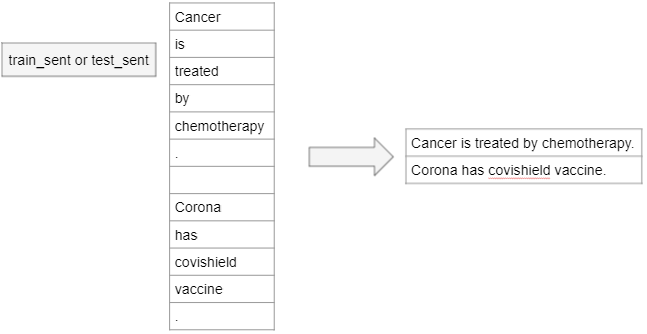

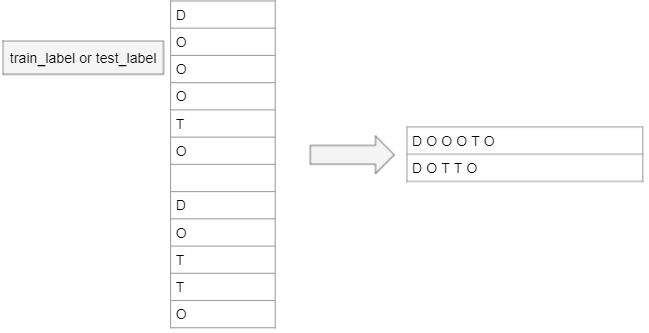

In [ ]:
# Reading the train and test sentences and labels
with open('train_sent', 'r') as train_sent_file:
  train_words = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels_by_word = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_words = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels_by_word = test_labels_file.readlines()

In [ ]:
# Sanity check to see that the number of tokens and no. of corresponding labels match.
print("Count of tokens in training set\n","No. of words: ",len(train_words),"\nNo. of labels: ",len(train_labels_by_word))
print("\n\nCount of tokens in test set\n","No. of words: ",len(test_words),"\nNo. of labels: ",len(test_labels_by_word))

Count of tokens in training set
 No. of words:  48501 
No. of labels:  48501


Count of tokens in test set
 No. of words:  19674 
No. of labels:  19674


In [ ]:
# Function to combine tokens belonging to the same sentence.
def convert_to_sentences(dataset):
    sentence_list = []
    sentence = ""
    for entity in dataset:
        if entity != '\n':
            sentence = sentence + entity[:-1] + " "
        else:
            sentence_list.append(sentence)
            sentence = ""
    return sentence_list

In [ ]:
# Converting tokens to sentences and individual labels to sequences of corresponding labels.
train_sentences = convert_to_sentences(train_words)
train_labels = convert_to_sentences(train_labels_by_word)
test_sentences = convert_to_sentences(test_words)
test_labels = convert_to_sentences(test_labels_by_word)

In [ ]:
print("First five training sentences and their labels:\n")
for i in range(5):
    print(train_sentences[i],"\n",train_labels[i],"\n", len(train_sentences[i]),"\n", len(train_labels[i]),"\n")

First five training sentences and their labels:

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )  
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O  
 232 
 90 

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )  
 O O O O O O O O O O O O O O O O O O O O O O O O O  
 101 
 50 

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )  
 O O O O O O O O O O O O O O O  
 76 
 30 

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )  
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O  
 188 
 76 

Arrest of dilation was the most common in

In [ ]:
print("First five test sentences and their labels:\n")
for i in range(5):
    print(test_sentences[i],"\n",test_labels[i],"\n")

First five test sentences and their labels:

Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )  
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O  

As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration  
 O O O O O O O O O O O O O O O O O O O  

The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period  
 O O O O O O O O O O O O O O O O O O O O O O O O  

There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )  
 O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O  

Fluctuations in ambient temperature are inversely correlat

### Count the number of sentences in the processed train and test dataset

In [ ]:
print("Number of sentences in the train dataset: {}".format(len(train_sentences)))
print("Number of sentences in the test dataset: {}".format(len(test_sentences)))

Number of sentences in the train dataset: 2599
Number of sentences in the test dataset: 1056


### Count the number of lines of labels in the processed train and test dataset.

In [ ]:
print("Number of lines of labels in the train dataset: {}".format(len(train_labels)))
print("Number of lines of labels in the test dataset: {}".format(len(test_labels)))

Number of lines of labels in the train dataset: 2599
Number of lines of labels in the test dataset: 1056


In [ ]:
for i in range(len(train_sentences)):
  if 'hereditary' in train_sentences[i]:
    print(i, train_sentences[i])

68 OBJECTIVE : To investigate phenotypic characteristics of families potentially linked to the hereditary prostate cancer 1 ( HPC1 ) locus on chromosome 1q24-25 
77 Our study shows that a significant fraction of hereditary prostate cancers are diagnosed in advanced stages , emphasizing the clinical importance of early detection in men potentially carrying prostate cancer susceptibility genes 
91 RESULTS : Incidence of subsequent cancers was statistically significantly elevated only in the 961 patients with hereditary retinoblastoma , in whom 190 cancers were diagnosed , vs 6.3 expected in the general population ( relative risk ( RR ) , 30 ( 95 % confidence interval , 26-47 ) ) 
92 Cumulative incidence ( +/-SE ) of a second cancer at 50 years after diagnosis was 51.0 % ( +/-6.2 % ) for hereditary retinoblastoma , and 5.0 % ( +/-3.0 % ) for nonhereditary retinoblastoma 
93 All 114 sarcomas of diverse histologic types occurred in patients with hereditary retinoblastoma 
325 Mutations in o

In [ ]:
for i in range(len(test_sentences)):
  if 'hereditary' in test_sentences[i]:
    print(i, test_sentences[i])

36 FAMILIES : A total of 74 North American families with hereditary prostate cancer 
37 CONCLUSIONS : Families that provide evidence for segregation of an altered HPC1 gene are characterized by multiple cases of prostate cancer that , in most respects , are indistinguishable from nonhereditary cases 
46 < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy 


In [ ]:
train_labels[93]

'O O D O O O O O O O O O D '

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [ ]:
# Creating a combined dataset from training and test sentences, since this is an Exploratory analysis.
combined = train_sentences + test_sentences
print("Number of sentences in combined dataset (training + test): {}".format(len(combined)))

Number of sentences in combined dataset (training + test): 3655


In [ ]:
# Creating a list of tokens which have PoS tag of 'NOUN' or 'PROPN'
noun_propn = []         # Initiating list for nouns and proper nouns
pos_tag = []            # initiating list for corresponding PoS tags.
model = spacy.load("en_core_web_sm")
for sent in combined:
    for token in model(sent):
        if token.pos_ in ['NOUN', 'PROPN']:
           noun_propn.append(token.text)
           pos_tag.append(token.pos_)
print("No. of tokens in combined dataset with PoS tag of 'NOUN' or 'PROPN': {}".format(len(noun_propn)))

No. of tokens in combined dataset with PoS tag of 'NOUN' or 'PROPN': 24311


In [ ]:
print(len(pos_tag))

24311


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [ ]:
noun_pos = pd.DataFrame({"NOUN_PROPN":noun_propn,"POS_tag":pos_tag})
print("Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN' \n")
print(noun_pos["NOUN_PROPN"].value_counts().head(25))

Top 25 comon tokens with PoS tag of 'NOUN' or 'PROPN' 

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             88
effects          85
results          79
women            77
TO_SEE           74
use              74
cases            71
surgery          71
risk             71
analysis         70
rate             67
response         66
survival         65
children         64
Name: NOUN_PROPN, dtype: int64


## Defining features for CRF





In [ ]:
# Let's define the features to get the feature value for one word.
# Analysis of PoS tags - Independent assignment for words vs Contextual assignment in a sentence.
sentence = train_sentences[1]
sent_list = sentence.split()
position = 2

word = sent_list[position]        # Extracting word for PoS tag analysis.

print(sentence)

# Independent assignment of PoS tag.
print("PoS tag of word in isolation\nWord:",word,"--",model(word)[0].pos_,"\n")

# Contextual assignment of PoS.
print("PoS tag of all words in sentence with context in tact.")
for token in model(sentence):
    print(token.text, "--", token.pos_)

# Modified workflow to obtain PoS tag of specific word in question with context.
print("Result of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence in-tact.")
cnt = 0
for token in model(sentence):
      postag = token.pos_
      if (token.text == word) and (cnt == position):
          break
      cnt += 1
print("Word:", word,"POSTAG:",postag)

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 ) 
PoS tag of word in isolation
Word: cesarean -- VERB 

PoS tag of all words in sentence with context in tact.
The -- DET
total -- ADJ
cesarean -- ADJ
rate -- NOUN
was -- AUX
14.4 -- NUM
% -- NOUN
( -- PUNCT
344 -- NUM
of -- ADP
2395 -- NUM
) -- PUNCT
, -- PUNCT
and -- CCONJ
the -- DET
primary -- ADJ
rate -- NOUN
was -- AUX
11.4 -- NUM
% -- NOUN
( -- PUNCT
244 -- NUM
of -- ADP
2144 -- NUM
) -- PUNCT
Result of modified workflow to obtain PoS tag of word at a specific position while keeping context within sentence in-tact.
Word: cesarean POSTAG: ADJ


In [ ]:
# Function to obtain contextual PoS tagger.
def contextual_pos_tagger(sent_list,position):
    '''Obtaining PoS tag for individual word with sentence context in-tact.
       If the PoS tag is obtained for a word individually, it may not capture the context of use in the sentence and may assign the incorrect PoS tag.'''

    sentence = " ".join(sent_list)          # Sentence needs to be in string format to process it with spacy model. List of words won't work.
    posit = 0                               # Initialising variable to record position of word in joined sentence to compare with the position of the word under considertion.
    for token in model(sentence):
        postag = token.pos_
        if (token.text == word) and (posit == position):
            break
        posit += 1
    return postag

In [ ]:
# Define the features to get the feature values for one word.
def getFeaturesForOneWord(sent_list, position):
  word = sent_list[position]

  # Obtaining features for current word
  features = [
    'word.lower=' + word.lower(),                                   # serves as word id
    'word.postag=' + contextual_pos_tagger(sent_list, position),    # PoS tag of current word
    'word[-3:]=' + word[-3:],                                       # last three characters
    'word[-2:]=' + word[-2:],                                       # last two characters
    'word.isupper=%s' % word.isupper(),                             # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),                             # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper()                # is the word starting with a capital letter
  ]

  if(position > 0):
    prev_word = sent_list[position-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(),                               # previous word
    'prev_word.postag=' + contextual_pos_tagger(sent_list, position - 1), # PoS tag of previous word
    'prev_word.isupper=%s' % prev_word.isupper(),                         # is the previous word in all uppercase
    'prev_word.isdigit=%s' % prev_word.isdigit(),                         # is the previous word a number
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()            # is the previous word starting with a capital letter
  ])
  else:
    features.append('BEG')                                                # feature to track begin of sentence

  if(position == len(sent_list)-1):
    features.append('END')                                                # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [ ]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, position) for position in range(len(sentence_list))]

In [ ]:
# Checking feature extraction
example_sentence = train_sentences[5]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[0]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age 


['word.lower=cesarean',
 'word.postag=NOUN',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=True',
 'BEG']

In [ ]:
# features[4]

### Write a code/function to get the labels of a sentence

In [ ]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [ ]:
# Checking label extraction
example_labels = getLabelsInListForOneSentence(train_labels[5])
print(example_labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset

In [ ]:
train_sentences_df = pd.DataFrame(train_sentences, columns = ['Text'])
test_sentences_df = pd.DataFrame(test_sentences, columns = ['Text'])

In [ ]:
train_sentences_df['features'] = train_sentences_df['Text'].apply(lambda x: getFeaturesForOneSentence(x))
test_sentences_df['features'] = test_sentences_df['Text'].apply(lambda x: getFeaturesForOneSentence(x))

In [ ]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

# X_train = []
# for i in range(len(train_sentences)):
#   print(i)
#   X_train.append(getFeaturesForOneSentence(train_sentences[i]))
#   print(getFeaturesForOneSentence(train_sentences[i]))

# X_test = []
# for i in range(len(test_sentences)):
#   print(i)
#   X_test.append(getFeaturesForOneSentence(test_sentences[i]))

In [ ]:
X_train = train_sentences_df['features'].to_list()
X_test = test_sentences_df['features'].to_list()

### Define the labels as the target variable for test and the train dataset

In [ ]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

### Note: CRF suite is not working, so used a differnt way to train crf model

In [ ]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

AttributeError: ignored

AttributeError: ignored

AttributeError: ignored

In [ ]:
import pycrfsuite

# Create a new CRF model
crf = pycrfsuite.Trainer()

# Add training data to the model
for x_seq, y_seq in zip(X_train, Y_train):
    crf.append(x_seq, y_seq)

# Set the parameters of the model
crf.set_params({
    'c1': 1.0,  # coefficient for L1 regularization
    'c2': 1e-3,  # coefficient for L2 regularization
    'max_iterations': 300,
    'feature.possible_transitions': True
})

# Train the CRF model
crf.train('your_model_file.crfsuite')

# You can now use the trained model for prediction
tagger = pycrfsuite.Tagger()
tagger.open('your_model_file.crfsuite')

# Example prediction
Y_pred = [tagger.tag(x_seq) for x_seq in X_test]

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 22617
Seconds required: 0.108

L-BFGS optimization
c1: 1.000000
c2: 0.001000
num_memories: 6
max_iterations: 300
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 24001.572296
Feature norm: 1.000000
Error norm: 12372.737036
Active features: 10405
Line search trials: 1
Line search step: 0.000012
Seconds required for this iteration: 0.045

***** Iteration #2 *****
Loss: 22634.959674
Feature norm: 0.877742
Error norm: 8692.004977
Active features: 8230
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.024

***** Iteration #3 *****
Loss: 21748.593497
Feature norm: 0.648132
Error norm: 12506.145524
Active features: 5778
Line search trials: 1
Line search step: 1.000000
Seconds required for th

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [ ]:
#Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [ ]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9123400056209285

### Test Case

In [ ]:
print("Sentence: ",test_sentences[46])
print("Actual labels:    ", Y_test[46])
print("Predicted labels: ", Y_pred[46])

Sentence:  < TO_SEE > CONTEXT : There is a substantial risk of a second cancer for persons with hereditary retinoblastoma , which is enhanced by radiotherapy 
Actual labels:     ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'O', 'O', 'O', 'O', 'O', 'T']


In [ ]:
print(X_test[46])

[['word.lower=<', 'word.postag=NOUN', 'word[-3:]=<', 'word[-2:]=<', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'BEG'], ['word.lower=to_see', 'word.postag=NOUN', 'word[-3:]=SEE', 'word[-2:]=EE', 'word.isupper=True', 'word.isdigit=False', 'words.startsWithCapital=True', 'prev_word.lower=<', 'prev_word.postag=NOUN', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=False'], ['word.lower=>', 'word.postag=NOUN', 'word[-3:]=>', 'word[-2:]=>', 'word.isupper=False', 'word.isdigit=False', 'words.startsWithCapital=False', 'prev_word.lower=to_see', 'prev_word.postag=NOUN', 'prev_word.isupper=True', 'prev_word.isdigit=False', 'prev_words.startsWithCapital=True'], ['word.lower=context', 'word.postag=NOUN', 'word[-3:]=EXT', 'word[-2:]=XT', 'word.isupper=True', 'word.isdigit=False', 'words.startsWithCapital=True', 'prev_word.lower=>', 'prev_word.postag=NOUN', 'prev_word.isupper=False', 'prev_word.isdigit=False', 'prev_words.startsWit

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

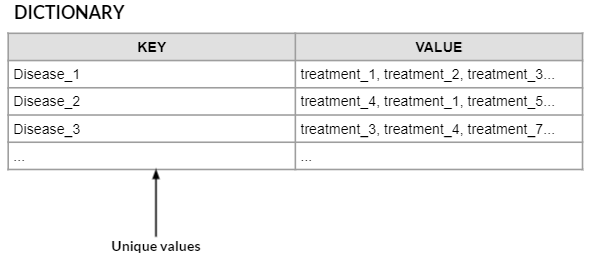

In [ ]:
# Extracting a dictionary of all the predicted diseases from our test data and the corresponding treatments.
# Assumption: For each identified disease, one of the treatments is in the same sentence as the disease exists.
disease_treatment = {}
for i in range(len(Y_pred)):
    cnt_disease = 0
    cnt_treatment = 0
    diseases = [""]
    treatment = [""]
    length = len(Y_pred[i])
    for j in range(length):
        if (Y_pred[i][j] == 'D'):
            diseases[cnt_disease] += (X_test[i][j][0].split('=')[1] + " ")
            if j < length - 1:
                if (Y_pred[i][j+1] != 'D'):
                    diseases[cnt_disease] = diseases[cnt_disease][:-1]
                    cnt_disease += 1
                    diseases.append("")
                diseases[cnt_disease] = diseases[cnt_disease][:-1]
                cnt_disease += 1
                diseases.append("")

        if (Y_pred[i][j] == 'T'):
            treatment[cnt_treatment] += (X_test[i][j][0].split('=')[1] + " ")
            if j < length - 1:
                if (Y_pred[i][j+1] != 'T'):
                    treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                    cnt_treatment += 1
                    treatment.append("")
            else:
                treatment[cnt_treatment] = treatment[cnt_treatment][:-1]
                cnt_treatment += 1
                treatment.append("")

    diseases.pop(-1)
    treatment.pop(-1)

    # To our dictionary, add or append treatments to the diseases identified from the current sentence, if any.
    if len(diseases) > 0:
        for disease in diseases:
            if disease in disease_treatment.keys():
                # Extend treatment list if other treatments for the particular disease already exist
                disease_treatment[disease].extend(treatment)
            else:
                # Creating list of treatments for particular disease if it doesn not exist already.
                disease_treatment[disease] = treatment


In [ ]:
disease_treatment = {}

for i in range(len(Y_pred)):
    cnt_disease = 0
    cnt_treatment = 0
    diseases = [""]
    treatment = [""]
    length = len(Y_pred[i])

    for j in range(length):
        if (Y_pred[i][j] == 'D'):
            diseases[cnt_disease] += (X_test[i][j][0].split('=')[1] + " ")
            # Concatenate consecutive words for multi-word diseases
            if j < length - 1 and Y_pred[i][j+1] == 'D':
                continue
            diseases[cnt_disease] = diseases[cnt_disease].strip()
            cnt_disease += 1
            diseases.append("")

        if (Y_pred[i][j] == 'T'):
            treatment[cnt_treatment] += (X_test[i][j][0].split('=')[1] + " ")
            if j < length - 1 and Y_pred[i][j+1] != 'T':
                treatment[cnt_treatment] = treatment[cnt_treatment].strip()
                cnt_treatment += 1
                treatment.append("")
            elif j == length - 1:
                treatment[cnt_treatment] = treatment[cnt_treatment].strip()
                cnt_treatment += 1
                treatment.append("")

    diseases.pop(-1)
    treatment.pop(-1)

    # To our dictionary, add or append treatments to the diseases identified from the current sentence, if any.
    if len(diseases) > 0:
        for disease in diseases:
            if disease in disease_treatment.keys():
                # Extend treatment list if other treatments for the particular disease already exist
                disease_treatment[disease].extend(treatment)
            else:
                # Creating list of treatments for particular disease if it does not exist already.
                disease_treatment[disease] = treatment

In [ ]:
# Displaying dictionary of extracted diseases and potential treatments.
disease_treatment


{'gestational diabetes cases': ['good glycemic control'],
 'trisomy 18 fetuses': [],
 'preeclampsia': [],
 'severe preeclampsia': [],
 'asymmetric double hemiplegia': [],
 'a subchorial placental hematoma': [],
 'reversible nonimmune hydrops fetalis': [],
 'breast and/or ovarian cancer': [],
 'breast cancer': ['hormone replacement therapy',
  'vaccination',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'vaccination',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'prostate cancers': [],
 'hereditary prostate cancer': [],
 'multiple sclerosis': ['interferon beta treatment',
  'intravenous immunoglobulin treatment'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'deafness': ['hearing aids'],
 'epilepsy': ['methylphenidate'],
 'unstable angina or non-q-wave myocard

In [ ]:
# Cleaned version
cleaned_dict = {}
for key in disease_treatment.keys():
    if disease_treatment[key] != []:
        cleaned_dict[key] = disease_treatment[key]
cleaned_dict

{'gestational diabetes cases': ['good glycemic control'],
 'breast cancer': ['hormone replacement therapy',
  'vaccination',
  'undergone subcutaneous mastectomy'],
 'ovarian cancer': ['hormone replacement therapy',
  'vaccination',
  'undergone subcutaneous mastectomy'],
 'prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'mutated prostate cancer': ['radical prostatectomy and iodine 125 interstitial radiotherapy'],
 'multiple sclerosis': ['interferon beta treatment',
  'intravenous immunoglobulin treatment'],
 'hereditary retinoblastoma': ['radiotherapy'],
 'deafness': ['hearing aids'],
 'epilepsy': ['methylphenidate'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'cerebral palsy': ['hyperbaric oxygen therapy'],
 'essential hypertension': ['moxonidine'],
 'cellulitis': ['g-csf therapy', 'intravenous antibiotic treatment'],
 'hemorrhagic stroke': ['double-bolu

In [ ]:
# Converting dictionary to a dataframe
cleaned_df = pd.DataFrame({"Disease":cleaned_dict.keys(),"Treatments":cleaned_dict.values()})
cleaned_df.head()

,Disease,Treatments
0,gestational diabetes cases,[good glycemic control]
1,breast cancer,"[hormone replacement therapy, vaccination, und..."
2,ovarian cancer,"[hormone replacement therapy, vaccination, und..."
3,prostate cancer,[radical prostatectomy and iodine 125 intersti...
4,mutated prostate cancer,[radical prostatectomy and iodine 125 intersti...


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [ ]:
search_item = 'hereditary retinoblastoma'
treatments = cleaned_dict[search_item]
print("Treatments for '{0}' is/are ".format(search_item), end = "")
for i in range(len(treatments)-1):
    print("'{}'".format(treatments[i]),",", end="")
print("'{}'".format(treatments[-1]))

Treatments for 'hereditary retinoblastoma' is/are 'radiotherapy'
